In [1]:
from tqdm import tqdm
from GeoConformalizedExplainer import GeoConformalizedExplainer
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from lime.lime_tabular import LimeTabularExplainer

C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Basic Functions

In [2]:
plt.rcParams['legend.fontsize'] = 16


def plot_s(b, k=3, size=50, filename=None, sub_titles=None, non_spatial=None, vmin=None, vmax=None, interpolation=None,
           cmap=plt.get_cmap('viridis', 36)):
    fig, axes = plt.subplots(1, k, figsize=(6 * k, 5), dpi=500)

    for i in range(k):
        ax = axes[i]
        if i in non_spatial:
            ax.scatter(b[i][0], b[i][1], s=5, color='black')
            ax.set_ylim(b[i][2], b[i][3])
            ax.set_xlim(-2.5, 2.5)
            ax.set_xlabel(r'$X_{}$'.format(i), fontsize=16)
            ax.xaxis.set_tick_params(labelsize=20)
            ax.yaxis.set_tick_params(labelsize=20)
            ax.grid(False)
        else:
            if vmin is None:
                v_min = np.floor(b[i].min() * 10) / 10
            else:
                v_min = vmin
            if vmax is None:
                v_max = np.ceil(b[i].max() * 10) / 10
            else:
                v_max = vmax
            c = ax.imshow(b[i].reshape(size, size), cmap=cmap, vmin=v_min, vmax=v_max, interpolation=interpolation)
            cb = fig.colorbar(c, ax=ax)
            cb.ax.tick_params(labelsize=20)
            ax.set_xticks(np.arange(-0.5, size, 5))
            ax.set_yticks(np.arange(-0.5, size, 5))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_axis_off()
            ax.tick_params(axis='x', colors=(0, 0, 0, 0))
            ax.tick_params(axis='y', colors=(0, 0, 0, 0))
        ax.set_title(sub_titles[i], fontsize=20, y=1.05)

    plt.savefig(filename, bbox_inches='tight')



In [3]:
def plot_uncertainty(u, k=3, filename=None, sub_titles=None, cmap='flare', s_limits=(5, 20), hue='geo_uncertainty',
                     size='shap_abs'):
    fig, axes = plt.subplots(1, k, figsize=(6 * k, 5), dpi=500)
    sns.set_style("white")

    for i in range(k):
        ax = axes[i]
        data = u[i]
        g = sns.scatterplot(data=data, x='x', y='y', hue=hue, size=size, palette=cmap, sizes=s_limits, legend=False,
                            edgecolor='.7', ax=ax)
        g.set(xlabel='', ylabel='', aspect='equal')
        ax.set_title(sub_titles[i], fontsize=20, y=1.05)

    plt.savefig(filename, bbox_inches='tight')

In [4]:
def plot_coverage(c, k=3, size=50, filename=None, sub_titles=None, colors=None, cmap=None):
    fig, axes = plt.subplots(1, k, figsize=(6 * k, 5), dpi=500)
    legend_elements = [Patch(facecolor=colors[0], edgecolor='.7', label='Not Covered'),
                       Patch(facecolor=colors[1], edgecolor='.7', label='Covered')]
    for i in range(k):
        ax = axes[i]
        ax.imshow(c[i].reshape(size, size), cmap=cmap, vmin=0, vmax=1)
        ax.legend(handles=legend_elements, loc='upper right', title='')
        ax.set_title(sub_titles[i], fontsize=20, y=1.05)
    plt.savefig(filename, bbox_inches='tight')

In [5]:
from scipy.stats import multivariate_normal

def noise_2d_generation(noise_level):
  print(noise_level)

 # noise_level=100

  x = np.linspace(-2, 2, 50)
  y = np.linspace(-2, 2, 50)
  X, Y = np.meshgrid(x, y)
  pos = np.dstack((X, Y))
  mean = [1, 1]
  covariance = [[2, 1], [1, 2]]
  rv = multivariate_normal(mean, covariance)
  n1 = rv.pdf(pos) * noise_level
  n1 = n1 - n1.mean()

  # Plot the distribution
  plt.contourf(X, Y, n1, levels=20, cmap='coolwarm')
  plt.colorbar(label='Density')
  plt.title('2D Distribution with Positive and Negative Values')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.show()

  gaussians = [
      multivariate_normal([3, 3], [[2, 0], [0, 2]]).pdf(pos),
      multivariate_normal([-3, -3], [[3, 1], [1, 3]]).pdf(pos),
      multivariate_normal([0, 0], [[4, 0], [0, 4]]).pdf(pos)
  ]

  n2 = (gaussians[0] - gaussians[1] + gaussians[2]) * noise_level
  n2 = n2 - n2.mean()

  # Plot the distribution
  plt.contourf(X, Y, n2, levels=20, cmap='coolwarm')
  plt.colorbar(label='value')
  plt.title('2D Distribution with Positive and Negative Values')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.show()

  return n1,n2

In [6]:
def noise_uniform_generation(noise_level):
    n1 = np.random.uniform(-0.05, 0.05, size=(50, 50)) * noise_level
    n2 = np.random.uniform(-0.05, 0.05, size=(50, 50)) * noise_level

    return n1,n2

In [7]:
def noise_2d_constant_generation(noise_level):
    x = np.linspace(-2, 2, 50)
    y = np.linspace(-2, 2, 50)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    mean = [1, 1]
    covariance = [[2, 1], [1, 2]]
    rv = multivariate_normal(mean, covariance)
    n3 = rv.pdf(pos) * noise_level
    n3 = n3 - n3.mean()
    return n3

In [8]:
def noise_uniform_constant_generation(noise_level):
    return np.random.uniform(-0.05, 0.05, size=(50, 50)) * noise_level

Processing noise level: 1
1


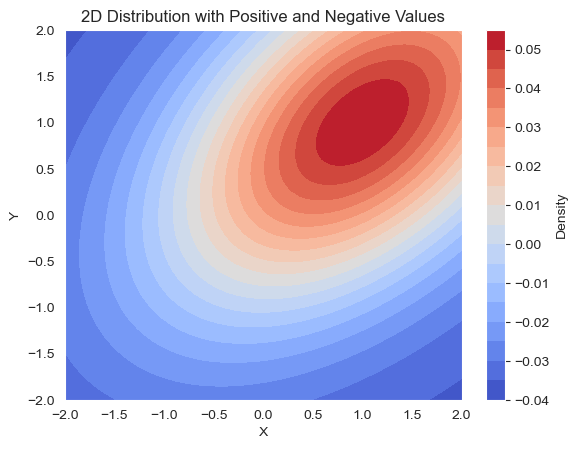

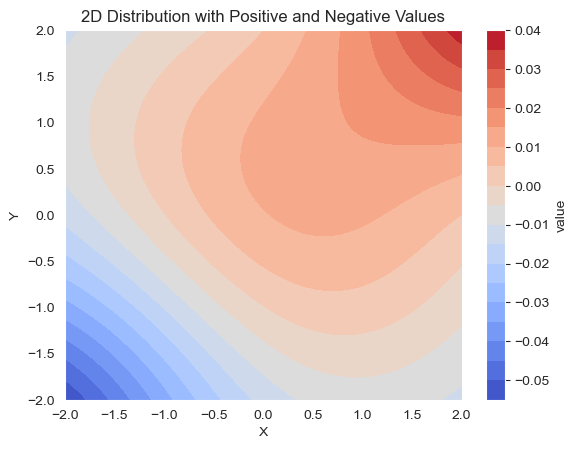

Explaining Variables
Explaining Variables
       X1_shap   X2_shap   X3_shap   X4_shap  x_coord_shap  y_coord_shap  \
0     1.912861  1.747170 -1.400831  0.925021      0.119351      0.014235   
1    -2.029773  1.625056 -1.299713  1.133875     -0.268956      0.012084   
2     5.765676 -2.071002  1.213923  1.072975     -0.322653      0.014519   
3     5.972316  1.680645 -1.445837  1.349488     -0.153851      0.059717   
4    -5.659091  2.195357 -1.615070  1.149337      0.296957      0.156631   
...        ...       ...       ...       ...           ...           ...   
2495 -6.112604 -2.181094  1.304459 -1.283249     -0.309251     -0.264412   
2496  1.972824 -1.911319 -1.782420 -1.155815     -0.259339     -0.114085   
2497 -5.907592 -2.051037  1.186115 -1.166614     -0.328181     -0.056344   
2498 -6.404391 -2.066988 -1.529735  1.230030     -0.300182      0.232305   
2499 -2.500646  1.926187 -1.519050 -1.307213      0.232615     -0.097167   

      X1_value  X2_value  X3_value  X4_value 

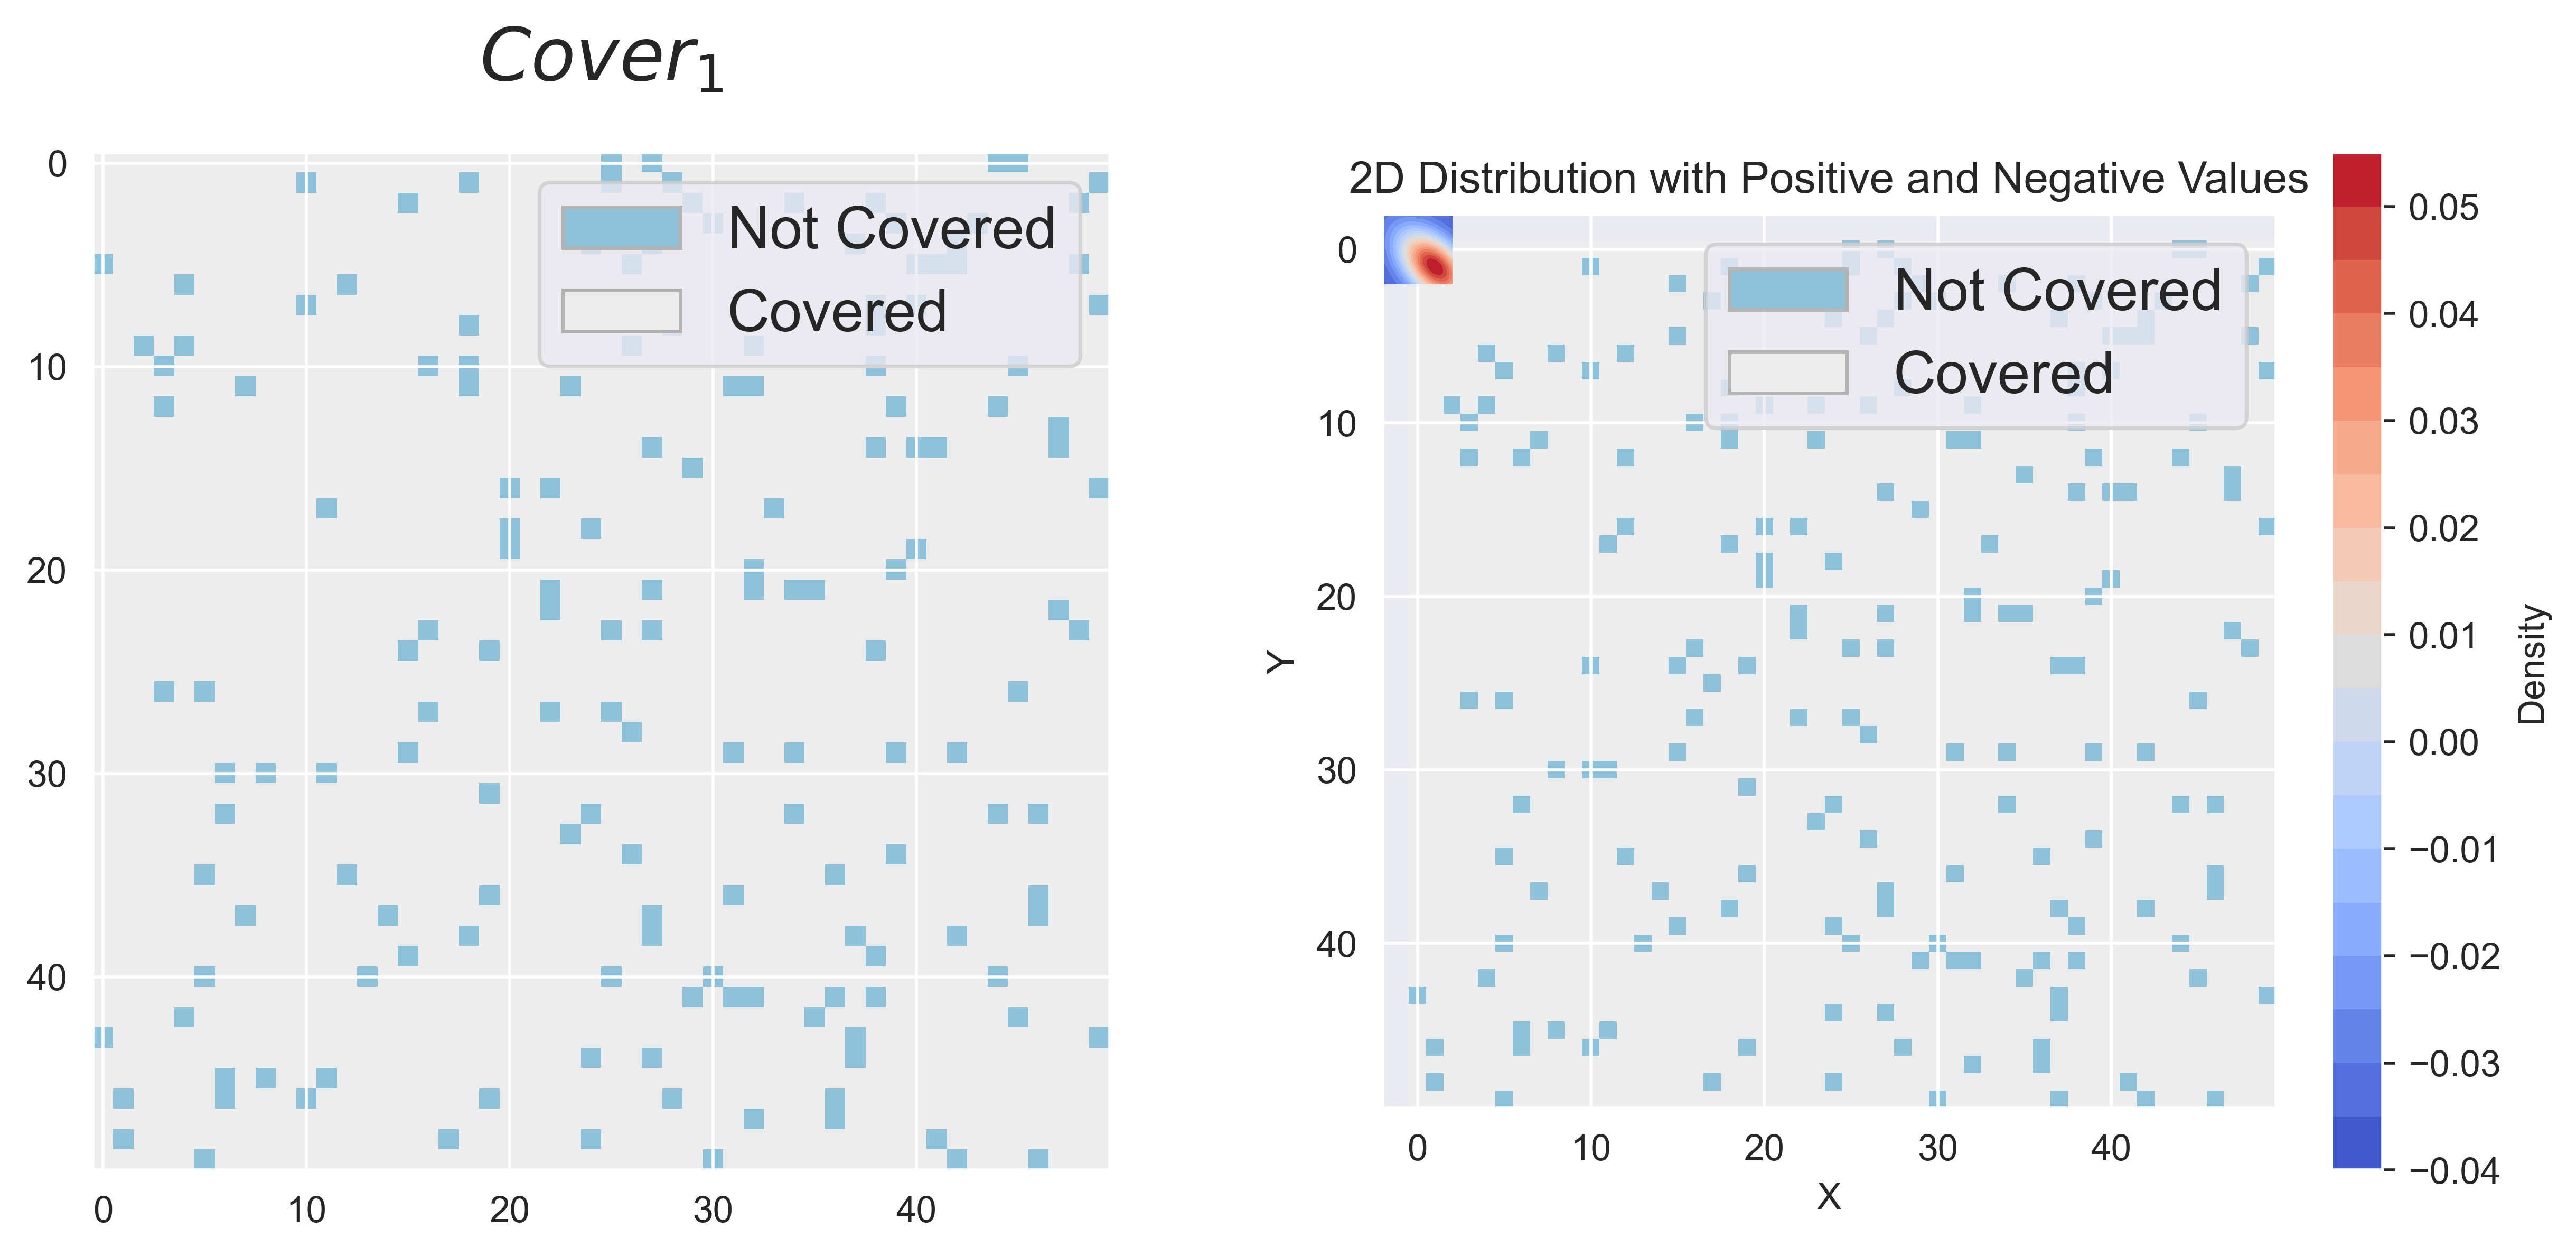

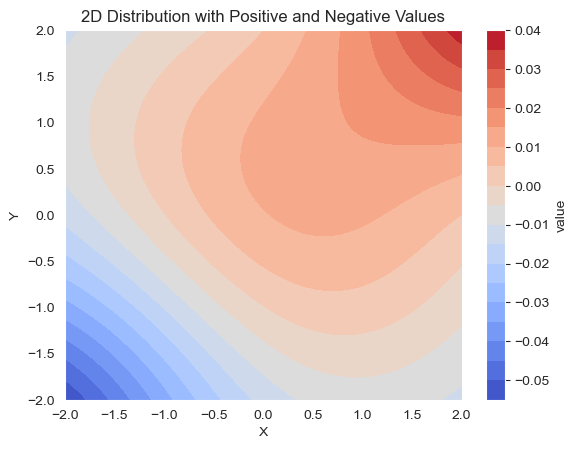

Explaining Variables
Explaining Variables
       X1_shap   X2_shap   X3_shap   X4_shap  x_coord_shap  y_coord_shap  \
0     1.912861  1.747170 -1.400831  0.925021      0.119351      0.014235   
1    -2.029773  1.625056 -1.299713  1.133875     -0.268956      0.012084   
2     5.765676 -2.071002  1.213923  1.072975     -0.322653      0.014519   
3     5.972316  1.680645 -1.445837  1.349488     -0.153851      0.059717   
4    -5.659091  2.195357 -1.615070  1.149337      0.296957      0.156631   
...        ...       ...       ...       ...           ...           ...   
2495 -6.112604 -2.181094  1.304459 -1.283249     -0.309251     -0.264412   
2496  1.972824 -1.911319 -1.782420 -1.155815     -0.259339     -0.114085   
2497 -5.907592 -2.051037  1.186115 -1.166614     -0.328181     -0.056344   
2498 -6.404391 -2.066988 -1.529735  1.230030     -0.300182      0.232305   
2499 -2.500646  1.926187 -1.519050 -1.307213      0.232615     -0.097167   

      X1_value  X2_value  X3_value  X4_value 

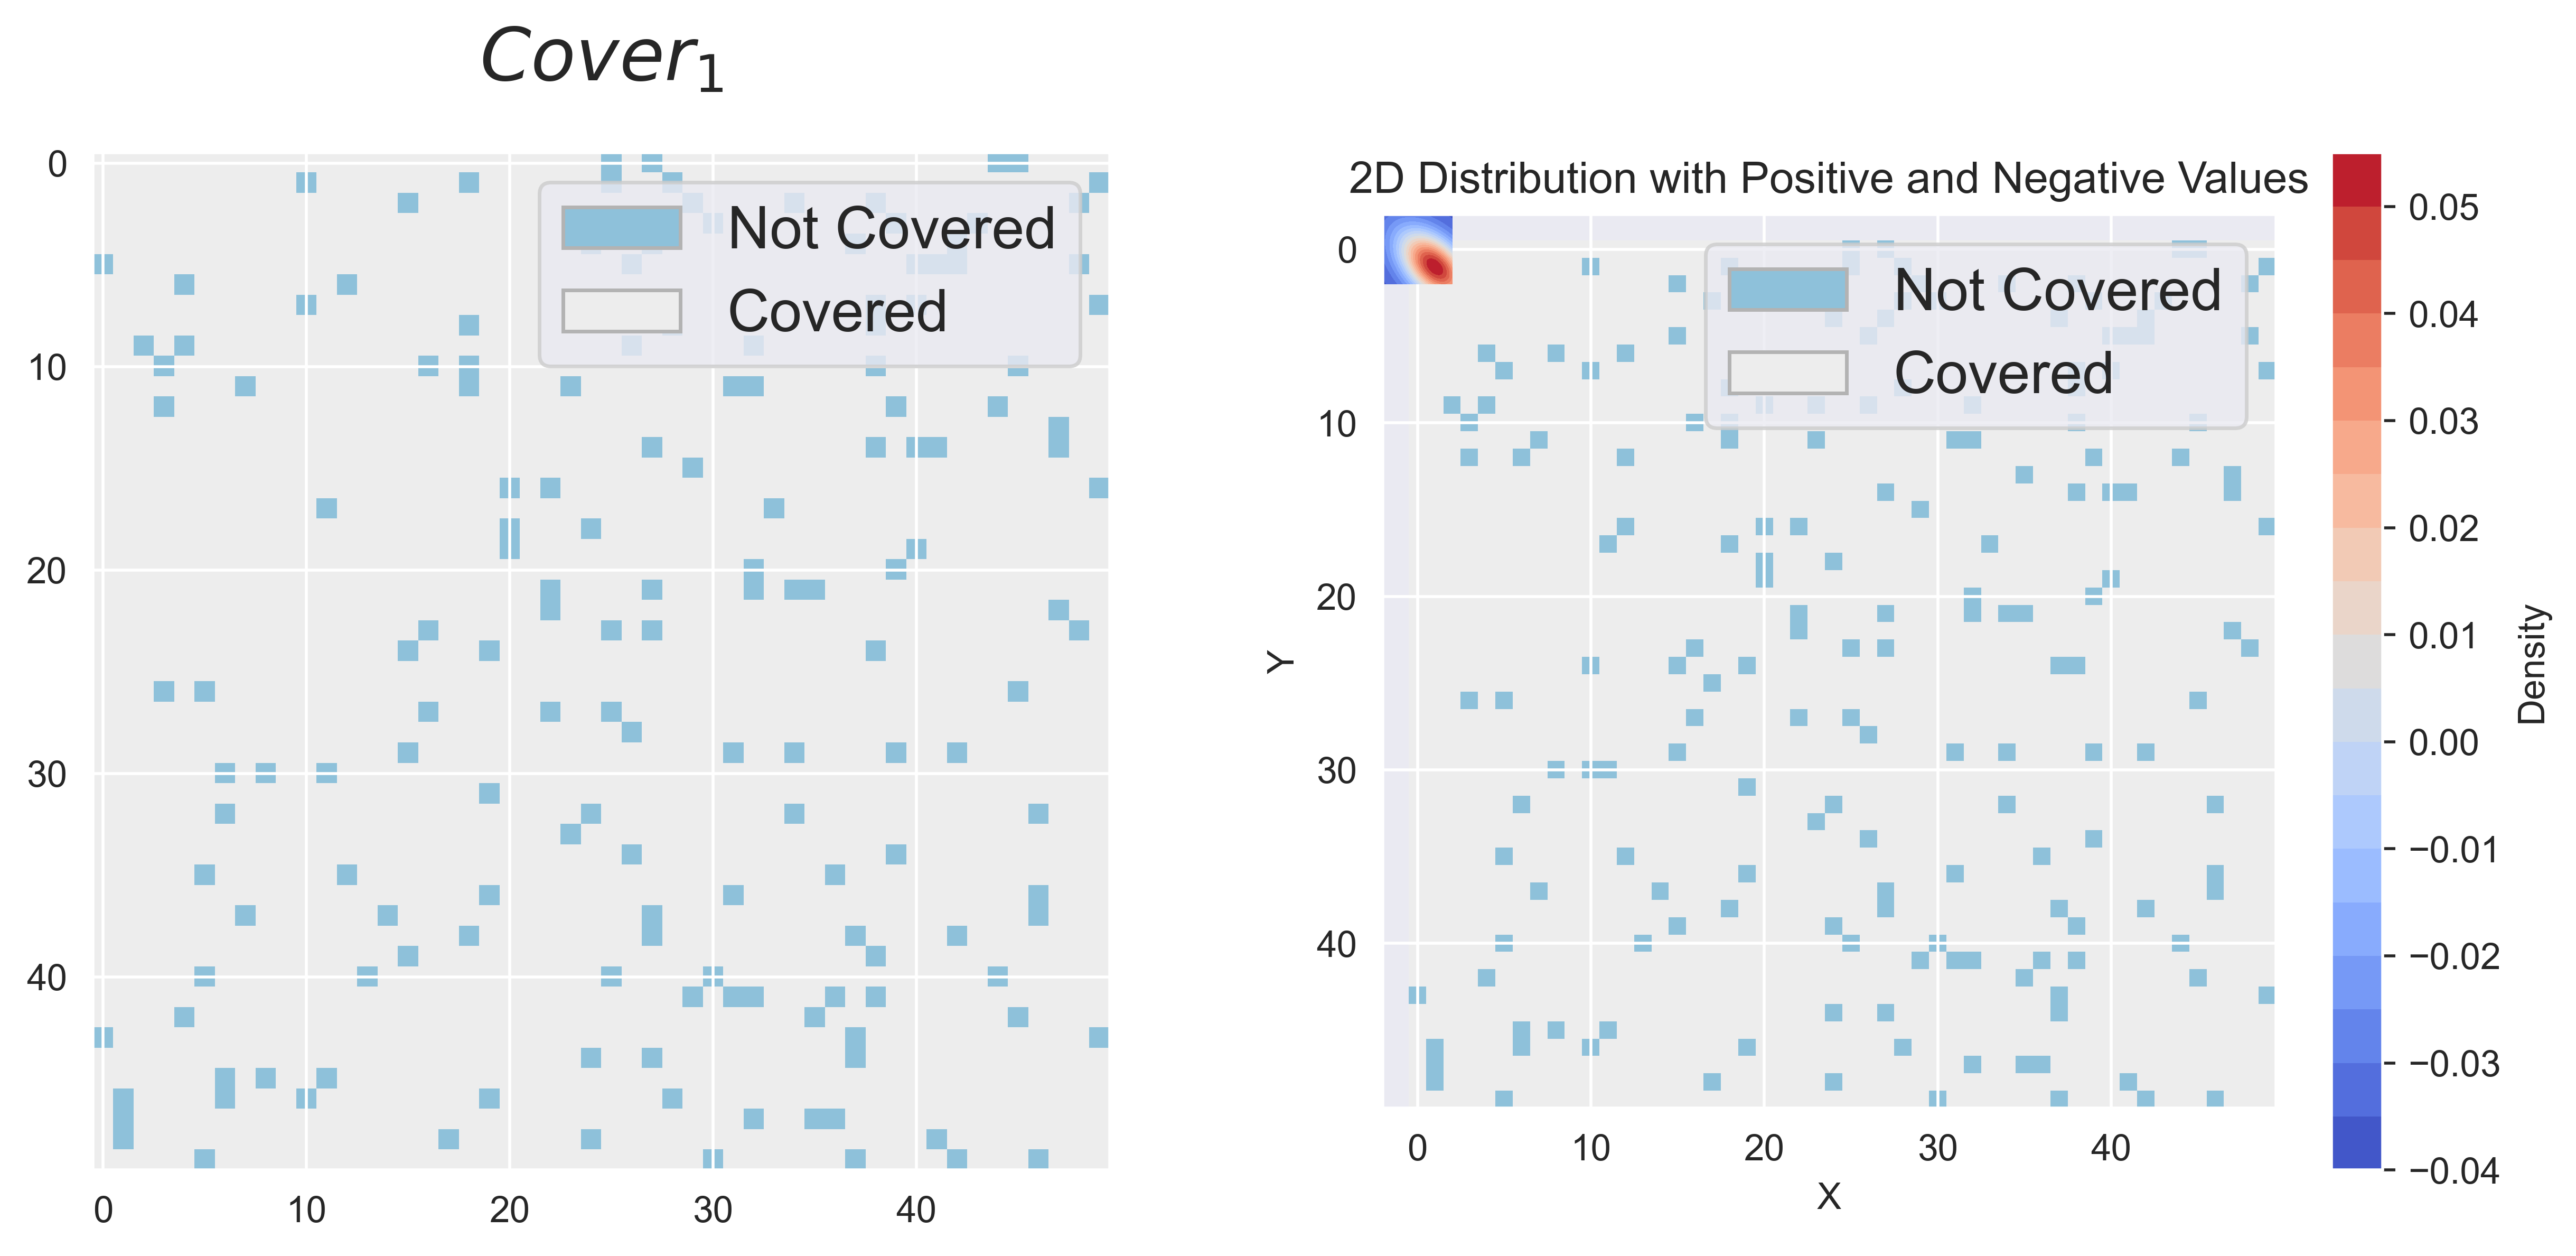

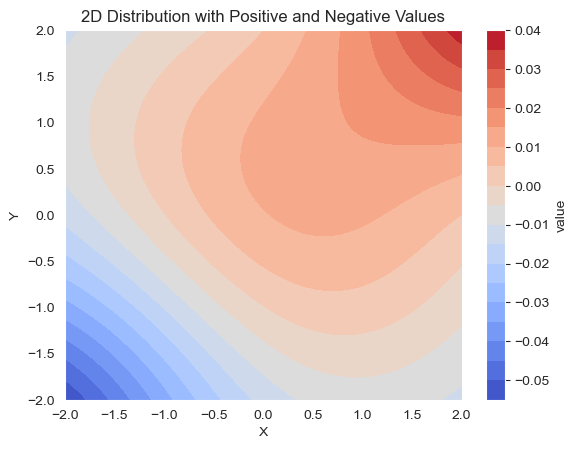

Explaining Variables
Explaining Variables
       X1_shap   X2_shap   X3_shap   X4_shap  x_coord_shap  y_coord_shap  \
0     1.912861  1.747170 -1.400831  0.925021      0.119351      0.014235   
1    -2.029773  1.625056 -1.299713  1.133875     -0.268956      0.012084   
2     5.765676 -2.071002  1.213923  1.072975     -0.322653      0.014519   
3     5.972316  1.680645 -1.445837  1.349488     -0.153851      0.059717   
4    -5.659091  2.195357 -1.615070  1.149337      0.296957      0.156631   
...        ...       ...       ...       ...           ...           ...   
2495 -6.112604 -2.181094  1.304459 -1.283249     -0.309251     -0.264412   
2496  1.972824 -1.911319 -1.782420 -1.155815     -0.259339     -0.114085   
2497 -5.907592 -2.051037  1.186115 -1.166614     -0.328181     -0.056344   
2498 -6.404391 -2.066988 -1.529735  1.230030     -0.300182      0.232305   
2499 -2.500646  1.926187 -1.519050 -1.307213      0.232615     -0.097167   

      X1_value  X2_value  X3_value  X4_value 

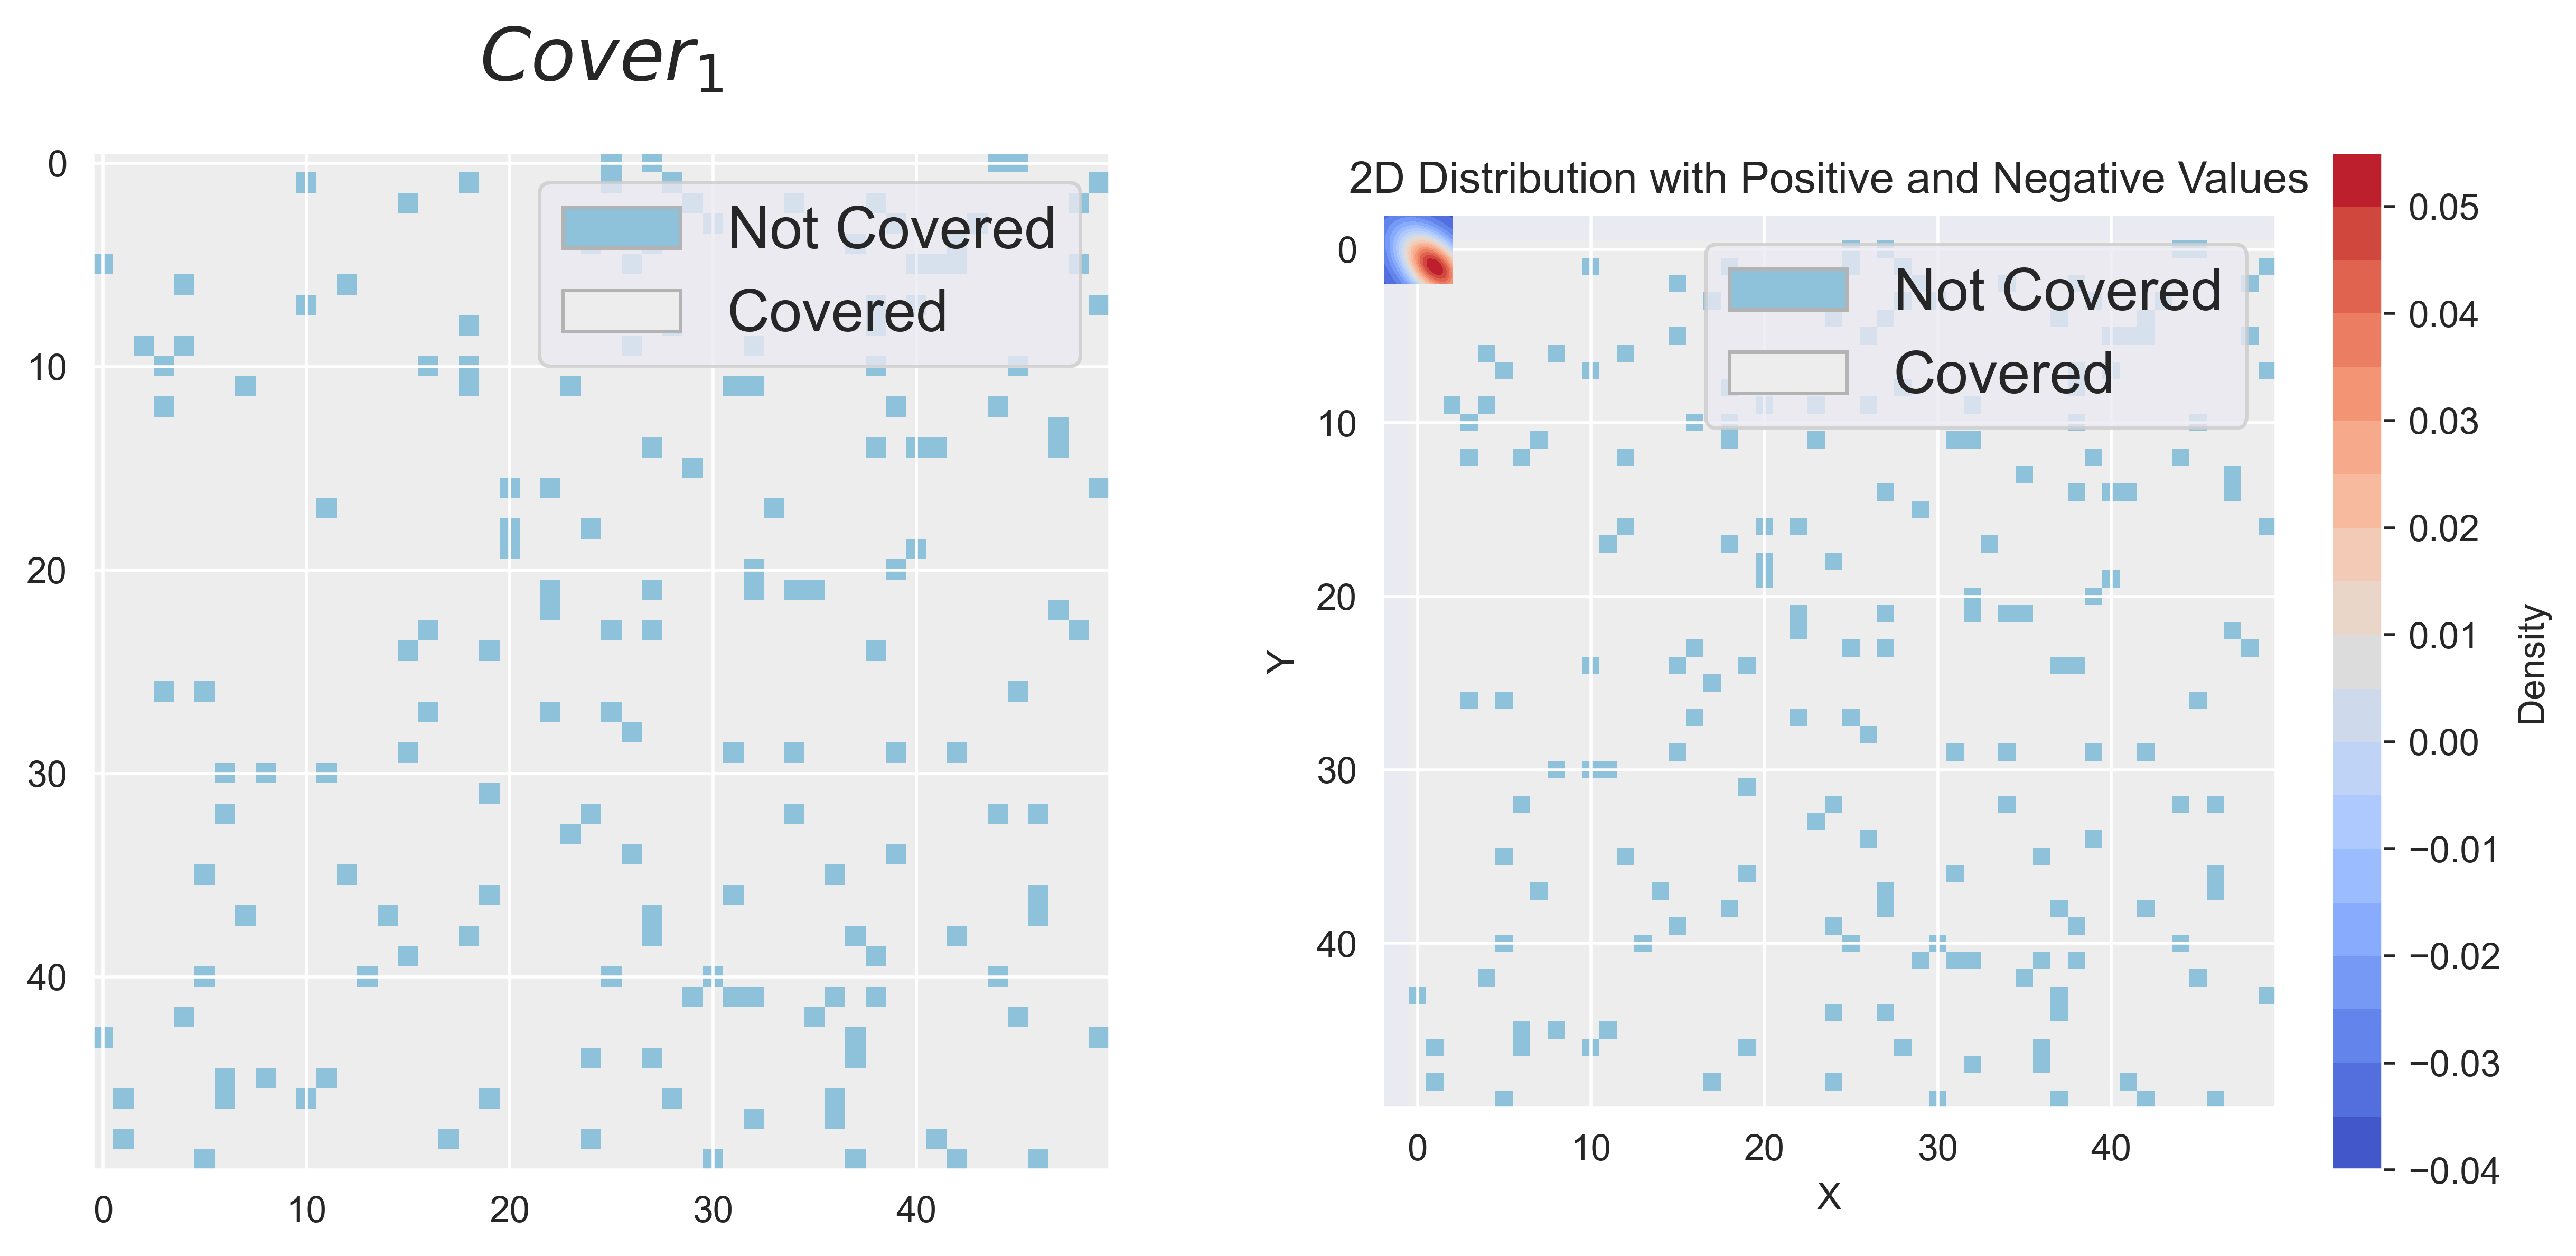

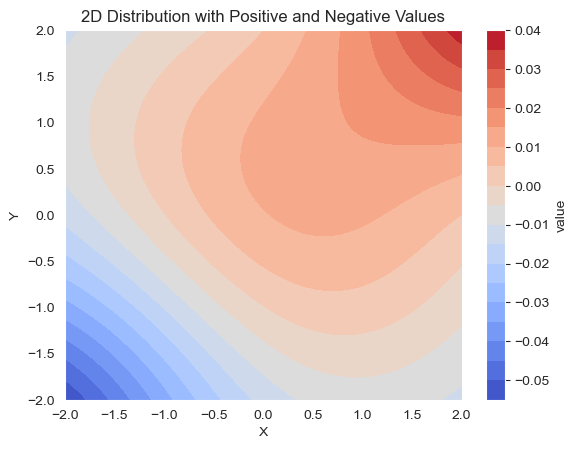

Explaining Variables
Explaining Variables


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import shap
from matplotlib.colors import ListedColormap


def Eva(noise_level, cached_results=None, option=0, noise_type='gaussian'):
    size = 50

    # 生成噪声数据
    # 系数噪声
    n1, n2 = noise_2d_generation(noise_level)
    # n1, n2 = noise_uniform_generation(noise_level)
    # 常数项噪声
    n3 = noise_2d_constant_generation(noise_level)
    # n3 = noise_uniform_constant_generation(noise_level)
    current_combination = f'{noise_type}_X1_only'
    if option == 0:
        current_combination = f'{noise_type}_X1_only'
        n2 = np.zeros((size, size))
        n3 = np.zeros((size, size))
    elif option == 1:
        current_combination = f'{noise_type}_X2_only'
        n1 = np.zeros((size, size))
        n3 = np.zeros((size, size))
    elif option == 2:
        current_combination = f'{noise_type}_X1_and_X2'
        n3 = np.zeros((size, size))
    elif option == 3:
        current_combination = f'constant_{noise_type}'
        n1 = np.zeros((size, size))
        n2 = np.zeros((size, size))

    # 生成随机数据
    np.random.seed(222)
    X1 = np.random.uniform(-2, 2, size * size)
    X2 = np.random.uniform(-2, 2, size * size)
    X3 = np.random.uniform(-2, 2, size * size)
    X4 = np.random.uniform(-2, 2, size * size)
    X = np.vstack([X1, X2, X3, X4]).T

    # 生成坐标数据
    u = np.array([np.linspace(0, size - 1, num=size)] * size).reshape(-1)
    v = np.array([np.linspace(0, size - 1, num=size)] * size).T.reshape(-1)
    coords = np.array(list(zip(u, v)))

    # 构建 DataFrame
    X_coords = pd.DataFrame(np.concatenate((X, np.array(coords)), axis=1),
                            columns=['X1', 'X2', 'X3', 'X4', 'x_coord', 'y_coord'])

    # 划分训练、校准和测试集
    loc = X_coords[['x_coord', 'y_coord']]
    X_train, X_temp, loc_train, loc_temp = train_test_split(X_coords, loc, train_size=0.8)
    X_calib, X_test, loc_calib, loc_test = train_test_split(X_temp, loc_temp, train_size=0.5)

    def true_model_predict_with_noise(X_coords):
        try:
            X_coords = X_coords.values
        except:
            pass
        u = X_coords[:, -1].astype(int)
        v = X_coords[:, -2].astype(int)
        b_1 = (u + v) / 49 * 3
        b_2 = 3 * (np.sin(-2 + 4 / 49 * u) * np.cos(-2 + 4 / 49 * v) + 1)
        f1 = (b_1 + n1[u, v]) * X_coords[:, 0]
        f2 = (b_2 + n2[u, v]) * X_coords[:, 1]
        f3 = X_coords[:, 2] ** 2
        f4 = np.abs(X_coords[:, 3]) * 2
        y_pred = f1 + f2 + f3 + f4 + n3[u, v]
        return y_pred

    def true_model_predict(X_coords):
        try:
            X_coords = X_coords.values
        except:
            pass
        u = X_coords[:, -1].astype(int)
        v = X_coords[:, -2].astype(int)
        b_1 = (u + v) / 49 * 3
        b_2 = 3 * (np.sin(-2 + 4 / 49 * u) * np.cos(-2 + 4 / 49 * v) + 1)
        f1 = b_1 * X_coords[:, 0]
        f2 = b_2 * X_coords[:, 1]
        f3 = X_coords[:, 2] ** 2
        f4 = np.abs(X_coords[:, 3]) * 2
        y_pred = f1 + f2 + f3 + f4
        return y_pred

    lime_explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, verbose=False, mode='regression')
    # 如果 cached_results 为 None，则计算 results
    if cached_results is None:
        # 定义 SHAP 值计算函数
        # def shap_value_f(x):
        #     explainer_ = shap.Explainer(true_model_predict, x, algorithm='auto')
        #     return explainer_(x).values
        # 定义 LIME 计算函数

        def lime_value_f(x):
            explanations = []
            for i in range(x.shape[0]):
                instance = x[i, :]
                res = lime_explainer.explain_instance(instance, true_model_predict, num_features=len(X_train.columns))
                explanation = [val[1] for val in res.as_list()]
                explanations.append(explanation)
            return np.array(explanations)

        # 初始化解释器
        explainer = GeoConformalizedExplainer(prediction_f=true_model_predict,
                                              x_train=X_train,
                                              x_calib=X_calib,
                                              coord_calib=loc_calib.values,
                                              miscoverage_level=0.1,
                                              band_width=25,
                                              shap_value_f=lime_value_f,
                                              feature_names=X_calib.columns)

        # 计算 SHAP 值
        results = explainer.uncertainty_aware_explain(x_test=X_coords, coord_test=loc.values)
        cached_results = results  # 缓存 results
    else:
        results = cached_results  # 使用缓存的 results

    # 定义带噪声的 SHAP 值计算函数
    # 系数噪声
    # def shap_value_f_with_noise(x):
    #     explainer_ = shap.Explainer(true_model_predict_with_noise, x, algorithm='auto')
    #     return explainer_(x).values
    def lime_value_f_with_noise(x):
            explanations = []
            for i in range(x.shape[0]):
                instance = x[i, :]
                res = lime_explainer.explain_instance(instance, true_model_predict_with_noise, num_features=len(X_train.columns))
                explanation = [val[1] for val in res.as_list()]
                explanations.append(explanation)
            return np.array(explanations)

    # 常数项噪声



    # 初始化带噪声的解释器
    explainer_with_noise = GeoConformalizedExplainer(prediction_f=true_model_predict_with_noise,
                                                          x_train=X_train,
                                                          x_calib=X_calib,
                                                          coord_calib=loc_calib.values,
                                                          miscoverage_level=0.1,
                                                          band_width=25,
                                                          shap_value_f=lime_value_f_with_noise,
                                                          feature_names=X_calib.columns)

    # 计算带噪声的 SHAP 值
    results_coef_noise = explainer_with_noise.uncertainty_aware_explain(x_test=X_coords, coord_test=loc.values)

    # 提取结果
    pred_results = results.result_geo
    print(pred_results)
    pred_results_coef_noise = results_coef_noise.result_geo

    # 计算 MSE、RMSE 和 R²
    diff_X1 = pred_results_coef_noise.X1_shap - pred_results.X1_shap
    mse_X1 = np.mean(diff_X1 ** 2)
    rmse_X1 = np.sqrt(mse_X1)
    r2_X1 = r2_score(pred_results.X1_shap, pred_results_coef_noise.X1_shap)

    diff_X2 = pred_results_coef_noise.X2_shap - pred_results.X2_shap
    mse_X2 = np.mean(diff_X2 ** 2)
    rmse_X2 = np.sqrt(mse_X2)
    r2_X2 = r2_score(pred_results.X2_shap, pred_results_coef_noise.X2_shap)

    # 计算覆盖率
    pred_results_coef_noise['X1_upper_bound_new'] = pred_results_coef_noise['X1_shap'] + pred_results_coef_noise[
        'X1_geo_uncertainty']
    pred_results_coef_noise['X1_lower_bound_new'] = pred_results_coef_noise['X1_shap'] - pred_results_coef_noise[
        'X1_geo_uncertainty']
    pred_results_coef_noise['X2_upper_bound_new'] = pred_results_coef_noise['X2_shap'] + pred_results_coef_noise[
        'X2_geo_uncertainty']
    pred_results_coef_noise['X2_lower_bound_new'] = pred_results_coef_noise['X2_shap'] - pred_results_coef_noise[
        'X2_geo_uncertainty']

    X1_cover = (pred_results['X1_shap'] <= pred_results_coef_noise['X1_upper_bound_new']) & (
            pred_results['X1_shap'] >= pred_results_coef_noise['X1_lower_bound_new'])
    X2_cover = (pred_results['X2_shap'] <= pred_results_coef_noise['X2_upper_bound_new']) & (
            pred_results['X2_shap'] >= pred_results_coef_noise['X2_lower_bound_new'])

    # result_true_file = f'/content/drive/MyDrive/Research/0-Xiayin_research/2_Conformal SHAP//result_X2_{noise_level}_true.csv'
    # pred_results.to_csv(result_true_file)
    pred_results.to_csv(f'./results_{noise_type}_lime/results_{noise_level}_true-{current_combination}-re.csv')

    # result_noise_file = f'/content/drive/MyDrive/Research/0-Xiayin_research/2_Conformal SHAP//result_X2_{noise_level}_noise.csv'
    # pred_results_coef_noise.to_csv(result_noise_file)
    pred_results_coef_noise.to_csv(f'./results_{noise_type}_lime/results_{noise_level}_noise-{current_combination}-re.csv')

    # 计算覆盖率均值
    X1_cover_mean = X1_cover.mean()
    X2_cover_mean = X2_cover.mean()

    # 输出结果
    print(f"Noise Level: {noise_level}")
    print("MSE:", mse_X1)
    print("RMSE:", rmse_X1)
    print("R²:", r2_X1)
    print("X1 Coverage Mean:", X1_cover_mean)
    print("X2 Coverage Mean:", X2_cover_mean)

    # 可视化覆盖率
    b_cover = [X1_cover.values, X2_cover.values]
    sub_titles = [r'$Cover_1$', r'$Cover_2$']
    binary_cmap = ListedColormap(['#8ec1da', '#ededed'])
    plot_coverage(b_cover, k=2, sub_titles=sub_titles, colors=['#8ec1da', '#ededed'],
                  cmap=binary_cmap,
                  filename=f'./results_{noise_type}_lime/Coverage-ConformalSHAP+Noise(Level={noise_level})-{current_combination}-re.pdf')

    result = pd.DataFrame({
        'noise_level': [noise_level],
        'mse_X1': [mse_X1],
        'rmse_X1': [rmse_X1],
        'r2_X1': [r2_X1],
        'mse_X2': [mse_X2],
        'rmse_X2': [rmse_X2],
        'r2_X2': [r2_X2],
        'X1_cover_mean': [X1_cover_mean],
        'X2_cover_mean': [X2_cover_mean],
    })

    print("Returning result:", result)
    return result, cached_results  # 返回结果和缓存的 results


# 示例：循环不同的噪声水平
noise_levels = [1]

# noise_levels = [10, 50, 100, 150, 200]

options = ['X1_only', 'X2_only', 'X1_and_X2', 'constant']
#
for i in range(len(options)):
    option = options[i]
    results_list = []
    cached_results = None  # 初始化缓存的 results

    for level in noise_levels:
        print(f"Processing noise level: {level}")
        result, cached_results = Eva(level, cached_results, option=i)  # 传入缓存的 results
        print(f"Appending result:\n{result}")
        results_list.append(result)  #
        print(f"Current results_list length: {len(results_list)}")

    # 将结果转换为 DataFrame
    results_df = pd.concat(results_list, ignore_index=True)  #

    # outpath='/content/drive/MyDrive/Research/0-Xiayin_research/2_Conformal SHAP/result_x2.csv'
    # results_df.to_csv(outpath)
    results_df.to_csv(f'./results_gaussian_lime/results_multi_level_noise-{option}-re.csv')


# results_list = []
# cached_results = None  # 初始化缓存的 results
#
# for level in noise_levels:
#     print(f"Processing noise level: {level}")
#     result, cached_results = Eva(level, cached_results, option=2)  # 传入缓存的 results
#     print(f"Appending result:\n{result}")
#     results_list.append(result)
#     print(f"Current results_list length: {len(results_list)}")
#
#     # 将结果转换为 DataFrame
# results_df = pd.concat(results_list, ignore_index=True)
#
# # outpath='/content/drive/MyDrive/Research/0-Xiayin_research/2_Conformal SHAP/result_x2.csv'
# # results_df.to_csv(outpath)
# results_df.to_csv(f'./results_gaussian_noise_xai_predictor/noise-100/results_multi_level_noise-X1_and_X2.csv')
# print(results_df)

In [10]:
results_uniform_noise

NameError: name 'results_uniform_noise' is not defined

In [10]:
results_list

[   noise_level        mse_X1       rmse_X1  r2_X1        mse_X2       rmse_X2  \
 0            1  6.823197e-30  2.612125e-15    1.0  6.959221e-30  2.638034e-15   
 
    r2_X2  X1_cover_mean  X2_cover_mean  
 0    1.0            1.0            1.0  ,
    noise_level        mse_X1       rmse_X1  r2_X1        mse_X2       rmse_X2  \
 0            5  6.625667e-30  2.574037e-15    1.0  7.233204e-30  2.689462e-15   
 
    r2_X2  X1_cover_mean  X2_cover_mean  
 0    1.0            1.0            1.0  ,
    noise_level        mse_X1       rmse_X1  r2_X1        mse_X2       rmse_X2  \
 0           10  6.736240e-30  2.595427e-15    1.0  6.774367e-30  2.602761e-15   
 
    r2_X2  X1_cover_mean  X2_cover_mean  
 0    1.0            1.0            1.0  ,
    noise_level        mse_X1       rmse_X1  r2_X1        mse_X2       rmse_X2  \
 0           20  6.416601e-30  2.533101e-15    1.0  7.058833e-30  2.656846e-15   
 
    r2_X2  X1_cover_mean  X2_cover_mean  
 0    1.0            1.0            1.0

In [11]:
results_df

,noise_level,mse_X1,rmse_X1,r2_X1,mse_X2,rmse_X2,r2_X2,X1_cover_mean,X2_cover_mean
0,1,6.823197e-30,2.612125e-15,1.0,6.959221e-30,2.638034e-15,1.0,1.0,1.0
1,5,6.625667e-30,2.574037e-15,1.0,7.233204e-30,2.689462e-15,1.0,1.0,1.0
2,10,6.736240e-30,2.595427e-15,1.0,6.774367e-30,2.602761e-15,1.0,1.0,1.0
3,20,6.416601e-30,2.533101e-15,1.0,7.058833e-30,2.656846e-15,1.0,1.0,1.0
4,30,6.887571e-30,2.624418e-15,1.0,7.305622e-30,2.702891e-15,1.0,1.0,1.0
5,40,6.757580e-30,2.599535e-15,1.0,7.078665e-30,2.660576e-15,1.0,1.0,1.0
6,50,6.449060e-30,2.539500e-15,1.0,6.885868e-30,2.624094e-15,1.0,1.0,1.0
7,60,6.406110e-30,2.531029e-15,1.0,6.691307e-30,2.586756e-15,1.0,1.0,1.0
8,70,6.999973e-30,2.645746e-15,1.0,7.435467e-30,2.726805e-15,1.0,1.0,1.0
9,80,6.924435e-30,2.631432e-15,1.0,6.782012e-30,2.604230e-15,1.0,1.0,1.0
